#  Pipe4 : 
## To classify severity of damage - minor, moderate or severe

In [4]:
import os
import urllib.request
import h5py
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter 
from IPython.display import Image, display, clear_output
from sklearn.metrics import classification_report, confusion_matrix

%matplotlib inline
sns.set_style('whitegrid')
sns.set_palette("cubehelix")

In [5]:
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, Activation, Dense, Dropout, Flatten
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.callbacks import ModelCheckpoint, History
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.regularizers import l2, l1

In [4]:
def save_bottleneck_features():
    datagen = ImageDataGenerator(rescale=1./255)
    
    model = VGG16(include_top=False, weights='imagenet')
    
    generator = datagen.flow_from_directory(train_data_dir, target_size=(img_width,img_height), batch_size=batch_size, class_mode=None, shuffle=False)
    bottleneck_features_train = model.predict(generator, nb_train_samples//batch_size)
    np.save(location+'/bottleneck_features_train.npy', bottleneck_features_train)
    
    generator = datagen.flow_from_directory(validation_data_dir, target_size=(img_width,img_height), batch_size=batch_size, class_mode=None, shuffle=False)
    bottleneck_features_validation = model.predict(generator, nb_validation_samples//batch_size)
    np.save(location+'/bottleneck_features_validation.npy', bottleneck_features_validation)

In [18]:
def train_categorical_model():
    train_data = np.load(location+'/bottleneck_features_train.npy')
    train_labels = np.array([0] * (nb_train_samples // 3) + [1] * (nb_train_samples // 3) + [2] * (nb_train_samples // 3))
    train_labels = to_categorical(train_labels)
    
    validation_data = np.load(location+'/bottleneck_features_validation.npy')
    validation_labels = np.array([0] * (nb_validation_samples // 3) + [1] * (nb_validation_samples // 3) + [2] * (nb_validation_samples // 3))
    validation_labels=np.append(validation_labels, 1)
    validation_labels=np.append(validation_labels, 1)
    validation_labels = to_categorical(validation_labels)
    
    model = Sequential()
    model.add(Flatten(input_shape=train_data.shape[1:]))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(3, activation='softmax'))
    
    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
    
    checkpoint = ModelCheckpoint(top_model_weights_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True,mode='auto')
    
    fit = model.fit(train_data, train_labels, epochs=epochs, batch_size=batch_size, validation_data=(validation_data,validation_labels), callbacks=[checkpoint])
    
    with open(location+'/top_history.txt', 'w') as f:
        json.dump(fit.history, f)
    
    return model, fit.history

In [1]:
def finetune_categorical_model():
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256,256,3))
    print("Model loaded.")
     
    top_model = Sequential()
    top_model.add(Flatten(input_shape=base_model.output_shape[1:]))
    top_model.add(Dense(256, activation='relu'))
    top_model.add(Dropout(0.5))
    top_model.add(Dense(3, activation='softmax'))
    
    model = Model(inputs=base_model.input, outputs=top_model(base_model.output))
    
    for layer in model.layers[:25]:
        layer.trainable = False
    optimizer = SGD(learning_rate=1e-4, momentum=0.9)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
    
    test_datagen = ImageDataGenerator(rescale=1./255)
    
    train_generator = train_datagen.flow_from_directory(train_data_dir, target_size=(img_height, img_width), batch_size=batch_size, class_mode='categorical')
    
    validation_generator = test_datagen.flow_from_directory(validation_data_dir, target_size=(img_height, img_width), batch_size=batch_size, class_mode='categorical')
    
    checkpoint = ModelCheckpoint(fine_tuned_model_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')
    
    fit = model.fit(train_generator, steps_per_epoch=nb_train_samples//batch_size, epochs=epochs, validation_data=validation_generator, validation_steps=nb_validation_samples//batch_size, verbose=1, callbacks=[checkpoint])
    
    with open(location+'/ft_history.txt', 'w') as f:
        json.dump(fit.history, f)
        
    return model, fit.history

In [7]:
def print_best_model_results(model_hist):
    best_epoch = np.argmax(model_hist['val_accuracy'])
    print('epoch:', best_epoch+1, ', val_acc:', model_hist['val_accuracy'][best_epoch], ', val_loss:', model_hist['val_loss'][best_epoch])

In [8]:
def plot_metrics(hist, stop=50):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
    axes = axes.flatten()
    
    axes[0].plot(range(stop), hist['accuracy'], label='Training')
    axes[0].plot(range(stop), hist['val_accuracy'], label='Validation')
    axes[0].set_title('Accuracy')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].legend(loc='lower right')
    
    axes[1].plot(range(stop), hist['loss'], label='Training')
    axes[1].plot(range(stop), hist['val_loss'], label='Validation')
    axes[1].set_title('Loss')
    axes[1].set_ylabel('Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].legend(loc='upper right')
    
    plt.tight_layout();
    
    print("Best Model:")
    print_best_model_results(hist)

In [9]:
def evaluate_categorical_model(model, directory, labels):
    datagen = ImageDataGenerator(rescale=1./255)
    
    generator = datagen.flow_from_directory(directory, target_size=(img_height,img_width), batch_size=batch_size, class_mode='categorical', shuffle=False)
    
    predictions = model.predict(generator, len(labels))
    
    pred_labels = [np.argmax(pred) for pred in predictions]
    
    print('')
    print(classification_report(validation_labels, pred_labels))
    print('')
    cm = confusion_matrix(validation_labels, pred_labels)
    return cm

## Image Dataset Details

In [24]:
location = 'D:/Dataset/New/data3a/P4'
loc='D:/Dataset/New/data3a/'
top_model_weights_path = location+'/top_model.weights.h5'
fine_tuned_model_path = location+'/ft_model.keras'

train_data_dir = loc+'/t'
validation_data_dir = loc+'/v'
train_samples = [len(os.listdir(train_data_dir+'/'+i)) for i in sorted(os.listdir(train_data_dir))]
nb_train_samples = sum(train_samples)
validation_samples = [len(os.listdir(validation_data_dir+'/'+i)) for i in sorted(os.listdir(validation_data_dir))]
nb_validation_samples = sum(validation_samples)

img_width, img_height = 256,256
epochs = 50
batch_size = 16

In [12]:
save_bottleneck_features()

Found 1383 images belonging to 3 classes.


C:\ProgramData\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


87/87 ━━━━━━━━━━━━━━━━━━━━ 94s 1s/step
Found 248 images belonging to 3 classes.
16/16 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step


In [19]:
d4_model, d4_history = train_categorical_model()

Epoch 1/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.4105 - loss: 7.7169
Epoch 1: val_accuracy improved from -inf to 0.63710, saving model to D:/Dataset/New/data3a/P4/top_model.weights.h5
87/87 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - accuracy: 0.4109 - loss: 7.6657 - val_accuracy: 0.6371 - val_loss: 0.8685
Epoch 2/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.5180 - loss: 1.0924
Epoch 2: val_accuracy did not improve from 0.63710
87/87 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - accuracy: 0.5179 - loss: 1.0925 - val_accuracy: 0.5524 - val_loss: 0.8177
Epoch 3/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.5631 - loss: 0.9346
Epoch 3: val_accuracy improved from 0.63710 to 0.66935, saving model to D:/Dataset/New/data3a/P4/top_model.weights.h5
87/87 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - accuracy: 0.5632 - loss: 0.9346 - val_accuracy: 0.6694 - val_loss: 0.7411
Epoch 4/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.6194 - loss: 0.8606
Epoch 4: val_accuracy did no

Best Model:
epoch: 13 , val_acc: 0.6774193644523621 , val_loss: 0.9146150946617126


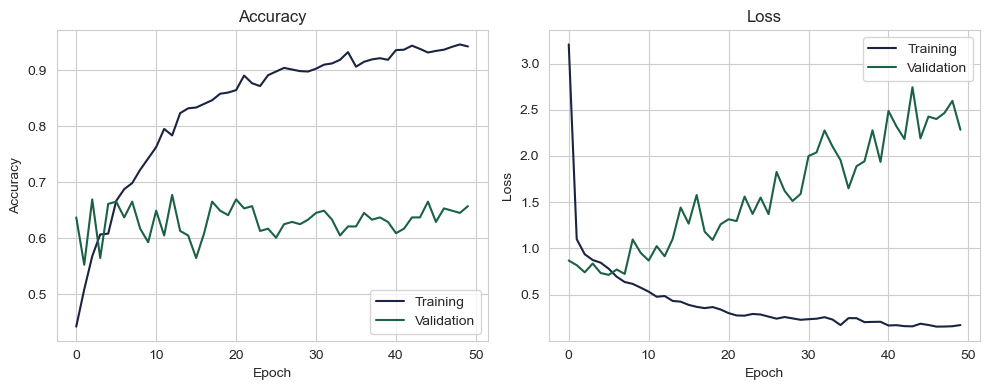

In [20]:
plot_metrics(d4_history)

In [27]:
ft_model, ft_history = finetune_categorical_model()

Model loaded.
Found 1383 images belonging to 3 classes.
Found 248 images belonging to 3 classes.
Epoch 1/50


C:\ProgramData\anaconda3\Lib\site-packages\keras\src\backend\tensorflow\trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3252 - loss: 1.6677
Epoch 1: val_accuracy improved from -inf to 0.30000, saving model to D:/Dataset/New/data3a/P4/ft_model.keras
86/86 ━━━━━━━━━━━━━━━━━━━━ 107s 1s/step - accuracy: 0.3252 - loss: 1.6674 - val_accuracy: 0.3000 - val_loss: 1.6579
Epoch 2/50
 1/86 ━━━━━━━━━━━━━━━━━━━━ 1:27 1s/step - accuracy: 0.2500 - loss: 1.8928

C:\ProgramData\anaconda3\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: val_accuracy improved from 0.30000 to 0.37500, saving model to D:/Dataset/New/data3a/P4/ft_model.keras
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.2500 - loss: 0.9574 - val_accuracy: 0.3750 - val_loss: 0.7814
Epoch 3/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3227 - loss: 1.6723
Epoch 3: val_accuracy did not improve from 0.37500
86/86 ━━━━━━━━━━━━━━━━━━━━ 105s 1s/step - accuracy: 0.3230 - loss: 1.6720 - val_accuracy: 0.3000 - val_loss: 1.6538
Epoch 4/50
 1/86 ━━━━━━━━━━━━━━━━━━━━ 1:29 1s/step - accuracy: 0.3125 - loss: 1.8894
Epoch 4: val_accuracy did not improve from 0.37500
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.3125 - loss: 0.9557 - val_accuracy: 0.3750 - val_loss: 0.8427
Epoch 5/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3447 - loss: 1.6360
Epoch 5: val_accuracy did not improve from 0.37500
86/86 ━━━━━━━━━━━━━━━━━━━━ 108s 1s/step - accuracy: 0.3448 - loss: 1.6359 - val_accuracy: 0.3000 - val_loss: 1.6673
Epoch 6/50
 1/86 ━━━

In [28]:
validation_labels = np.array([0] * validation_samples[0] + 
                             [1] * validation_samples[1] +
                             [2] * validation_samples[2])

In [31]:
def pipe32(image_path, model):
    urllib.request.urlretrieve(image_path, 'save.jpg')
    img = load_img('save.jpg', target_size=(256,256))
    x = img_to_array(img)
    x = x.reshape((1,)+x.shape)/255
    pred = model.predict(x)
    pred_labels = np.argmax(pred, axis=1)
    d = {0:'minor', 1:'moderate', 2:'severe'}
    for key in d.keys():
        if pred_labels[0] == key:
            print("Validating severity of damage....Result:",d[key])
    print("Severity assessment complete.")

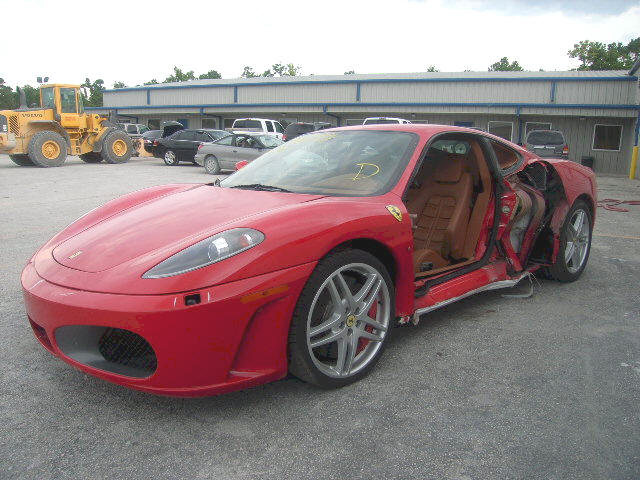

In [30]:
Image('http://repairablecars-forsale.com/photos/Exotic_Wrecked_Cars_F430_Spider_Red_Ferrari.jpg')

In [32]:
pipe32('http://repairablecars-forsale.com/photos/Exotic_Wrecked_Cars_F430_Spider_Red_Ferrari.jpg', ft_model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step
Validating severity of damage....Result: moderate
Severity assessment complete.
